In [313]:
import pandas as pd
import numpy as np
import requests 
#import config # gitignored file with API keys
import json 

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans 

import folium 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

#import matplotlib.cm as cm
#import matplotlib.colors as colors


matplotlib.style.use('ggplot')
sns.set(rc={'figure.figsize':(20,8.27)})
%matplotlib inline

# Define the urban area: ZIP, Price, Rent, Lat, and Lng 
## Pulling all zip codes for the urban area

In [324]:
# Source https://worldpostalcode.com/united-states/new-york/new-york-city 
# retrieved on 05/28/2020
df_zipcodes = pd.read_csv('nyc_boroughs.csv', index_col = 0)
df_zipcodes.head(2)

,zip,borough
0,10001,Manhattan
1,10002,Manhattan


In [325]:
df_zipcodes.shape

(240, 2)

This looks like a good sample of zip codes that can be used for the analysis

In [332]:
df_zipcodes.rename(columns={'borough':'Borough', 'zip':'Zipcode'}, inplace=True)
df_zipcodes.groupby('Borough').count()

,Zipcode
Borough,
Bronx,25
Brooklyn,43
Manhattan,96
Queens,63
Staten,13


## Adding Zillow price estimates 
Use the list of sample zip codes to get good price estimates, in my case, latest estimates of 2-bedroom condo units

In [344]:
# Source: https://www.zillow.com/research/data/
# retrieved on 05-18-2020
df_prices = pd.read_csv('condo_prices.csv', index_col=0)

In [345]:
# This data set contains zillow estimates for the entire nation
df_prices.shape

(10939, 299)

In [346]:
# Inspect the columns 
df_prices.head(2)

,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,215591.0,214255.0,...,1249908.0,1239499.0,1219219.0,1203053.0,1188642.0,1182534.0,1175894.0,1153407.0,1123011.0,1085220.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,194597.0,194456.0,...,403689.0,403756.0,403181.0,402122.0,401073.0,400025.0,399451.0,399424.0,400541.0,402007.0


In [347]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_prices.drop(df_prices.columns.difference(['RegionName', '2019-11-30']), 1, inplace=True)

In [348]:
df_nyc_prices = df_zipcodes.merge(df_prices, left_on='Zipcode', right_on='RegionName')
df_nyc_prices.shape

(157, 4)

Merged data set has less rows than original zip codes list but thats fine as there might have been some P.O boxes or reserved codes. The new list now has meaningful first feature - price estimate.

Check if all observations map to New York city boroughs or if there any unexpected values. Looks fine so far!

In [349]:
df_nyc_prices.groupby('Borough').count()

,Zipcode,RegionName,2019-11-30
Borough,,,
Bronx,16,16,16
Brooklyn,38,38,38
Manhattan,41,41,41
Queens,51,51,51
Staten,11,11,11


Finally, drop control column 'RegionName', rename the column to 'Price' and check if there are any missing values.

In [350]:
df_nyc_prices.rename(columns={'2019-11-30':'Price'}, inplace=True)
df_nyc_prices.drop(['RegionName'], axis=1, inplace=True)

In [351]:
df_nyc_prices['Price'].isna().values.any()

False

In [352]:
df_nyc_prices.head()

,Zipcode,Borough,Price
0,10001,Manhattan,1274766.0
1,10002,Manhattan,1103197.0
2,10003,Manhattan,1065001.0
3,10004,Manhattan,1236730.0
4,10005,Manhattan,1163758.0


## Addining Zillow rental estimates

In [353]:
df_rents=pd.read_csv('condo_rentals.csv', index_col = 0)

In [354]:
df_rents.shape

(13181, 119)

In [355]:
df_rents.head(2)

,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3031.0,3058.0,3031.0,3015.0,...,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1790.0,1787.0,1784.0,1774.0,...,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0


In [356]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_rents.drop(df_rents.columns.difference(['RegionName', '2019-11']), 1, inplace=True)

In [357]:
df_rents.head(2)

,RegionName,2019-11
RegionID,,
61639,10025,3873.0
84654,60657,NaN


In [358]:
df_nyc_prices_rents = df_nyc_prices.merge(df_rents, left_on='Zipcode', right_on='RegionName')
df_nyc_prices_rents.shape

(136, 5)

More observations (rows) were lost because not all zip codes had a rental estimate

In [359]:
df_nyc_prices_rents.groupby('Borough').count()

,Zipcode,Price,RegionName,2019-11
Borough,,,,
Bronx,16,16,16,15
Brooklyn,34,34,34,29
Manhattan,26,26,26,25
Queens,49,49,49,49
Staten,11,11,11,11


Moreover, from the grouped table above, it seems that some zip codes do have a price estimate but do not have rent estimate. So, drop missing values and check the data set.

Drop control column and rename column 'Rent'

In [360]:
df_nyc_prices_rents.rename(columns={'2019-11':'Rent'}, inplace=True)
df_nyc_prices_rents.drop(['RegionName'], axis=1, inplace=True)

In [362]:
df_nyc_prices_rents['Rent'].isna().values.any()

True

In [364]:
df_nyc_prices_rents.shape

(136, 4)

In [365]:
df_nyc_prices_rents.dropna(inplace=True)

In [366]:
df_nyc_prices_rents.shape

(129, 4)

In [367]:
df_nyc_prices_rents['Rent'].isna().values.any()

False

In [368]:
df_nyc_prices_rents.head(2)

,Zipcode,Borough,Price,Rent
0,10001,Manhattan,1274766.0,3667.0
1,10002,Manhattan,1103197.0,3759.0


## Visual exploratory analysis 

Inspect the rents visually with box plots

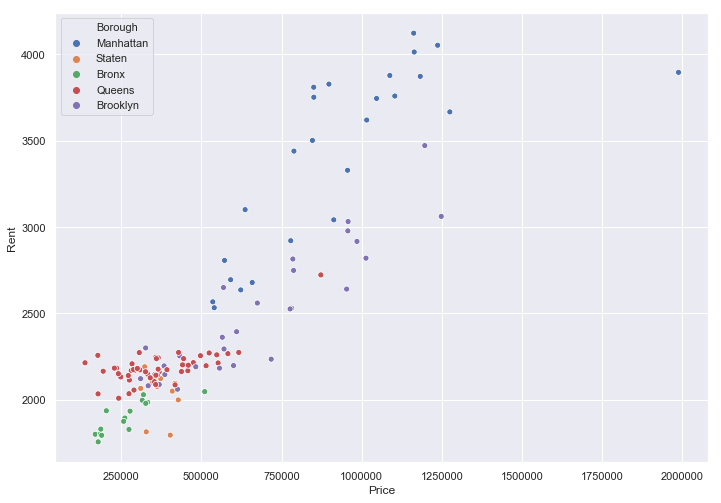

In [369]:
sns.scatterplot(x='Price', y='Rent', data=df_nyc_prices_rents, hue = 'Borough')
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

When plotting 'Rent' against 'Price" it seems that the data is not homegeneous at all. 

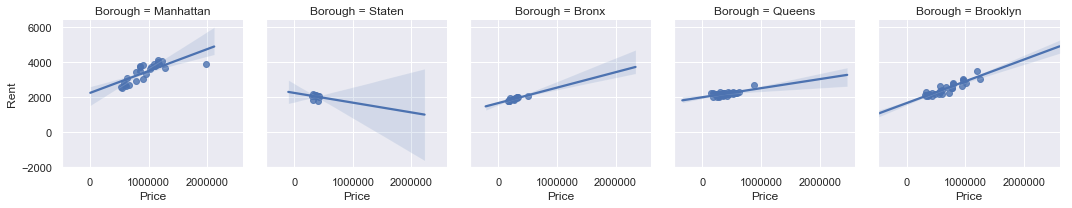

In [370]:
g1 = sns.lmplot(x='Price', y='Rent', data=df_nyc_prices_rents, ci=85,
                col='Borough', height=3, robust=False)
g1 = g1.set_axis_labels('Price', 'Rent')
plt.show()

Splitting by boroughs confirms this idea. When looking at the slope of regression lines, rent/price relationship appears to be different. There are at list 3 distinct groups: 1) Manhattan, 2) Staten,  and 3) Bronx, Queens and Brooklyn.

## Algorithmic *k*-means clustering 

In [371]:
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
X = df_nyc_prices_rents[['Price', 'Rent']]
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [381]:
k_means_cluster_centers = k_means.cluster_centers_
pd.DataFrame(k_means_cluster_centers, columns=['Price', 'Rent'])

,Price,Rent
0,3.237901e+05,2094.460526
1,6.511839e+05,2619.575758
2,1.116881e+06,3487.450000


In [382]:
labels = k_means.labels_

In [383]:
df_nyc_prices_rents["Cluster"] = labels
df_nyc_prices_rents.head(5)

,Zipcode,Borough,Price,Rent,Cluster
0,10001,Manhattan,1274766.0,3667.0,2
1,10002,Manhattan,1103197.0,3759.0,2
2,10004,Manhattan,1236730.0,4053.0,2
3,10005,Manhattan,1163758.0,4014.0,2
4,10006,Manhattan,850713.0,3752.0,1


In [384]:
df_nyc_prices_rents.groupby('Cluster').count()

,Zipcode,Borough,Price,Rent
Cluster,,,,
0,76,76,76,76
1,33,33,33,33
2,20,20,20,20


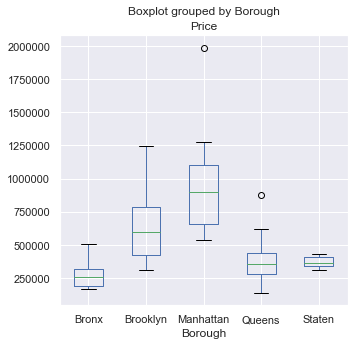

In [399]:
df_nyc_prices_rents.boxplot(column='Price', by='Borough', figsize=(5, 5), rot=0)
plt.show()

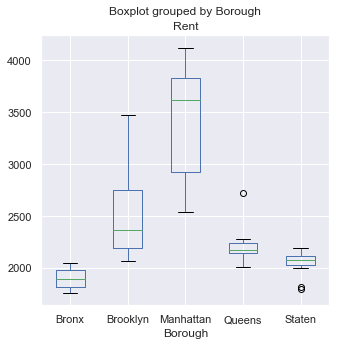

In [400]:
df_nyc_prices_rents.boxplot(column='Rent', by='Borough', figsize=(5, 5), rot=0)
plt.show()

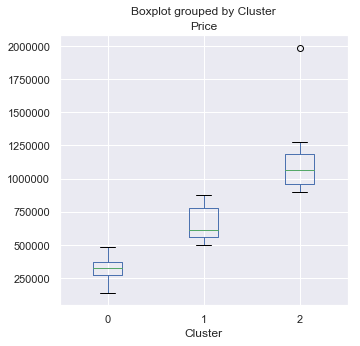

In [401]:
df_nyc_prices_rents.boxplot(column='Price', by='Cluster', figsize=(5, 5), rot=0)
plt.show()

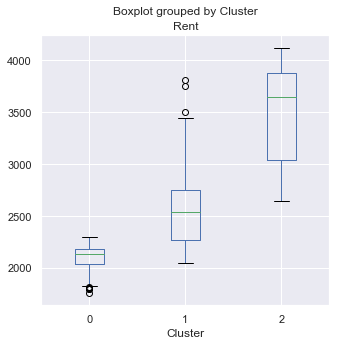

In [402]:
df_nyc_prices_rents.boxplot(column='Rent', by='Cluster', figsize=(5, 5), rot=0)
plt.show()

## Adding geospatial data

In [404]:
# Source: https://gist.github.com/erichurst/7882666#file-us-zip-codes-from-2013-government-data
# Retrieved on 05/28/200
#df_zip_coordinates = pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')
# Due to importance of these coordinates, I make a local csv copy
#df_zip_coordinates.to_csv('zip_coordinates.csv')

In [406]:
df_zip_coordinates= pd.read_csv('zip_coordinates.csv', index_col = 0)
df_zip_coordinates.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [407]:
df_nyc_prices_rents = df_nyc_prices_rents.merge(df_zip_coordinates, left_on='Zipcode', right_on='ZIP')

In [409]:
df_nyc_prices_rents.head()

,Zipcode,Borough,Price,Rent,Cluster,ZIP,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,2,10001,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,2,10002,40.715775,-73.986212
2,10004,Manhattan,1236730.0,4053.0,2,10004,40.688630,-74.018244
3,10005,Manhattan,1163758.0,4014.0,2,10005,40.706027,-74.008835
4,10006,Manhattan,850713.0,3752.0,1,10006,40.709614,-74.012954


In [410]:
df_nyc_prices_rents.drop(['ZIP'], axis=1, inplace=True)
df_nyc_prices_rents.shape

(128, 7)

In [411]:
df_nyc_prices_rents['LAT'].isna().values.any()

False

In [412]:
df_nyc_prices_rents['LNG'].isna().values.any()

False

In [413]:
df_nyc_prices_rents.head()

,Zipcode,Borough,Price,Rent,Cluster,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,2,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,2,40.715775,-73.986212
2,10004,Manhattan,1236730.0,4053.0,2,40.688630,-74.018244
3,10005,Manhattan,1163758.0,4014.0,2,40.706027,-74.008835
4,10006,Manhattan,850713.0,3752.0,1,40.709614,-74.012954


In [414]:
# Creat a local copy of teh entire data set for audit purposes:
#df_nyc_prices_rents.to_csv('nyc_pyces_rents.csv')

# Local Venues

## Connecting to Foursquares server and data pull

In [ ]:
CLIENT_ID = 'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [194]:
# TODO: focus on the most popular venues by zip code; and need at least 20 of same type

In [ ]:
# TODO:
# 1) load condo prices - sort for NYC only, store data file, box plot by zip
# 2) load condo rents  - sort and store NYC, box plot by zip
# 3) merge data sets on zip codes, scatter plot x = condo_princes y = condo_rents
# 4) run 3 or 4 centers clustering algorithms as shown in k-means
# 5) group zip codes by clusters and map them using folio
# 6) loand venues data
# 7) count most popular by clusters
# 8) run trees
# 9) plot top of the tree
# 10) check with lasso regression